# Focusing only on experiments 2j_a, 2m, 2n this plots graphs for stitching uninitialised networks as senders
## Initialisation

In [1]:
import datetime
from pandas.errors import EmptyDataError
import pandas as pd
import glob 


def logtofile(log_text, verbose=True):
    if verbose:
        print(log_text)
    with open(save_log_as, "a") as f:    
        print(log_text, file=f)


def csv_to_df(path):
    csv_files = glob.glob(path) 
      
    dfs = []
    for f in csv_files:       
        try:
            df = pd.read_csv(f)
            logtofile(f, False)
            if len(df) > 0:
                df['layer'] = df['name'].index + 1 
                dfs.append(df)
        except EmptyDataError:
            continue
            
    return pd.concat(dfs, ignore_index=True)

style_order = ['Correlated', 
               'Digit',  
               'Colour', 
               #'Colour-Only',  
               #'Mix', 
               'Baseline',  
               #'Noise'
              ]

# Experiment 2m - Accuracy after stitching randomly initialised network into unbias ( Digit) stitch trained on bias (Correlated) - 4 Epoch Trained
Networks trained for 4 epochs. Stitch trained for 10 epochs.

Logging to ./plot_results/2025-05-16_12-07-55_ranks_exp2m_log.txt
Check number of samples per model:
{'Digit': 480, 'Randomly Initialised': 480}
Check number of samples per model:
{'Digit': 15, 'Randomly Initialised': 15}


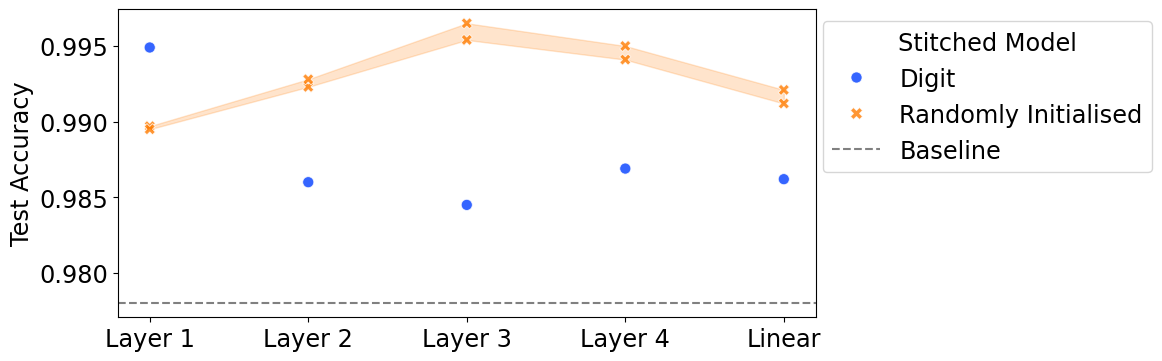

In [28]:
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp2m_log.txt"
save_log_as = f"./plot_results/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 

# styles to reproduce graph A5 of the NeurIPS paper "AllAcc/RankToDigit"
# But with datasets matching sender networks
makeAllRanks = True
if makeAllRanks:
    style_order = [#'Correlated', 
                   'Digit',  
                    'Randomly Initialised',
                   #'Colour', 
                   #'Colour-Only',  
                   #'Mix', 
                   #'BW',
                   #'Baseline',  
                   #'Noise'
                  ]
    send_models = {#'Baseline': '^unbias$',
                   #'Colour':         '^bg\d', # these three may learn colours as a shortcut
                   #'Colour-Only':     '^bgonly\d', 
                   #'Correlated':       '^bias\d',  
                   'Digit':     '^unbias\d', # these three have to learn to read digits
                   'Randomly Initialised': '^randinit\d', # randomly initialised network - not trained
                   #'Mix':        '^mix\d', 
                   #'BW':         '^bw\d',
                   #'Noise':      '^X\dunbias' # syntetic random data stitched in
                  }


# exp2m - randinit into Digit on Bias=Correlated dataset
csvs_from = os.path.join("./exp2_ms_with_colorMNIST/results_2m_rank/", "*.csv")
df1 = csv_to_df(csvs_from)

csvs_from = os.path.join("./exp2_ms_with_colorMNIST/results_4_epochs_rank/", "unbias?unbias-bias-57_2024-08-02_11-10-38_SEED57_*.csv")
df2 = csv_to_df(csvs_from)

df = pd.concat([df1, df2], ignore_index=True)
#df = df1
del df1 , df2 #, df3

# Edit names to match the whole-network naming
df['name'] = df['name'].str.replace(r'_rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^send_', '', regex=True)

df['sender'] = 'unknown'

sizes = {}
for k, v in send_models.items(): 
        
    # unsorted dataframe, but filtered to include only the data for one send model type
    selected_set = (df['model'].str.contains(v))
    df.loc[selected_set, 'sender'] = k
    sizes[k] = len((df['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# cheatingly noted the text names of the layers in order.
# Note that the stitch.s_conv1 layer appears first in the list, even though conceptually it 
# could be considered to be in the middle of the full network at the point of the cut
# This made sense for the truncated networks in part 1 but not 
layer_after_stitch = {3: 'features.4.0.conv1',
                      4: 'features.5.0.conv1',
                      5: 'features.6.0.conv1',
                      6: 'features.7.0.conv1',
                      7: 'originalfc'}

cat_order = ['features.4.0.conv1',  
             'features.5.0.conv1',  
             'features.6.0.conv1', 
             'features.7.0.conv1',  
             'originalfc']

# names for graph tick points as the above are specific to how I've cut and stitched
custom_labels = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Linear']

combined_condition = pd.Series([False] * len(df))

sizes = {}
for k, v in layer_after_stitch.items(): 

    model_match = (df['model'].str.contains(f"{k}"))
    layer_match = (df['name'].str.contains(v))
    combined_condition |= (model_match & layer_match)

    # Add in the reference model that has no stitch, was trained on unbias dataset but has bias data input to it
    if 'Baseline' in send_models:
        model_match = (df['model'].str.contains(send_models['Baseline']))
        layer_match = (df['name'].str.contains(v))
        combined_condition |= (model_match & layer_match)

df2 = df[combined_condition ].copy() 
df3 = df2[df2['sender'] != 'unknown'].copy()

#########################
sizes = {}
for k, v in send_models.items():         
    # Now that d3 has been filtered down, check again how many samples per model
    sizes[k] = len((df3['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")
#######################

# Sort the model column and create a categorical type with sorted categories 
# e.g models are X6bgonly or bgonly
df3['name'] = pd.Categorical(df3['name'], categories=cat_order, ordered=True)
# Create line plot
plt.figure(figsize=(9,4))


line_plot = sns.lineplot(data=df3, x='name', y='val_acc', hue='sender', style='sender', 
                         hue_order=style_order, style_order=style_order,
                         markers=False, dashes=False, lw=0, markersize=8, alpha=0.5, palette='bright',
                        errorbar=("pi", 100), legend=False)
# errorbar=("sd",1)) for standard deviation
# errorbar=("pi",100)) for all results
# Add markers for each individual data point
scatter_plot = sns.scatterplot(
    data=df3,
    x='name',
    y='val_acc',
    hue='sender',
    style='sender',
    hue_order=style_order,
    style_order=style_order,
    markers=True,
    s=64,  # Marker size
    alpha=0.8,
    palette='bright',
    #legend=False  # Avoid duplicate legends
)


#plt.title("Val Acc of Digit receiver stitched from senders at various layers")
#plt.xlabel('Layer Name')
plt.xlabel('')
plt.ylabel('Test Accuracy', fontsize='xx-large')
#plt.yscale('log')
#plt.xticks(rotation=0)
plt.tick_params(axis='both', labelsize='xx-large')

plt.axhline(y=0.978, color='gray', linestyle='--', label='Baseline')

handles, labels = line_plot.get_legend_handles_labels()
#sorted_labels_handles = sorted(zip(labels, handles))
unsorted_labels_handles = zip(labels, handles)
labels, handles = zip(*unsorted_labels_handles)
plt.legend(handles, labels, title='Stitched Model', loc='upper right', bbox_to_anchor=(1.5, 1), fontsize='xx-large', title_fontsize='xx-large')
#plt.legend().remove()
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)

plt.savefig(f"./plot_results/2m_lin_post_stitch_acc.pdf", bbox_inches='tight')
plt.show()


## Calculate accuracies

In [7]:
# Calculate validation accuracy

formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp2m_log.txt"
save_log_as = f"./plot_results/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 

# exp2 colour_MNIST
csvs_from = os.path.join("./exp2_ms_with_colorMNIST/results_2m_rank/", "*.csv")
df1 = csv_to_df(csvs_from)

# The models which have no stitch - use to get a first point on the graph for training against real data
ref_models  = {
               #'Colour':         '^bg$', # these three may learn colours as a shortcut
               #'Colour-Only':     '^bgonly$', 
               #'Correlated':       '^bias$',  
               'Digit':       '^unbias$', # these three have to learn to read digits            
               #'Mix':        '^mix$', 
               #'BW':         '^bw$',
               # 'Colour-Only 3': '^bgonly3',
               # 'Colour-Only 4': '^bgonly4',
               # 'Colour-Only 5': '^bgonly5',
               # 'Colour-Only 6': '^bgonly6',
               # 'Colour-Only 7': '^bgonly7',
               # 'Colour-Only 8': '^bgonly8',
            }

combined_condition = pd.Series([False] * len(df))

accuracies = {}
stddevs = {}
for k, v in ref_models.items(): 

    model_match = (df['model'].str.contains(v))
    layer_match = (df['name'].str.contains('features.0'))
    condition = (model_match & layer_match)
    print(f"For {k} found {sum(condition)} examples")
    #combined_condition |= condition
    #print(df[condition]['val_acc'])
    #print(df[condition]['val_acc'].mean())
    accuracies[k] = df[condition]['val_acc'].mean()
    stddevs[k] = df[condition]['val_acc'].std()

print("The following networks with validation accuracies measured against Bias (Correlated) dataset")
formatted_acc = {key: f"{value:.4f}" for key, value in accuracies.items()} 
print(formatted_acc)

print("The following networks with stddev of  accuracies measured against Bias (Correlated) dataset")
formatted_std = {key: f"{value:.4f}" for key, value in stddevs.items()} 
print(formatted_std)


Logging to ./plot_results/2025-05-14_15-40-10_ranks_exp2m_log.txt
For Digit found 2 examples
The following networks with validation accuracies measured against Bias (Correlated) dataset
{'Digit': '0.9780'}
The following networks with stddev of  accuracies measured against Bias (Correlated) dataset
{'Digit': '0.0001'}


# Experiment 2n - Accuracy after stitching randomly initialised network into BG-Only
(versus BW model evaluated with BW dataset)


Logging to ./plot_results/2025-05-14_15-56-50_ranks_exp2n_log.txt
Check number of samples per model:
{'Randomly Initialised': 327, 'BW': 327}
Check number of samples per model:
{'Randomly Initialised': 10, 'BW': 10}


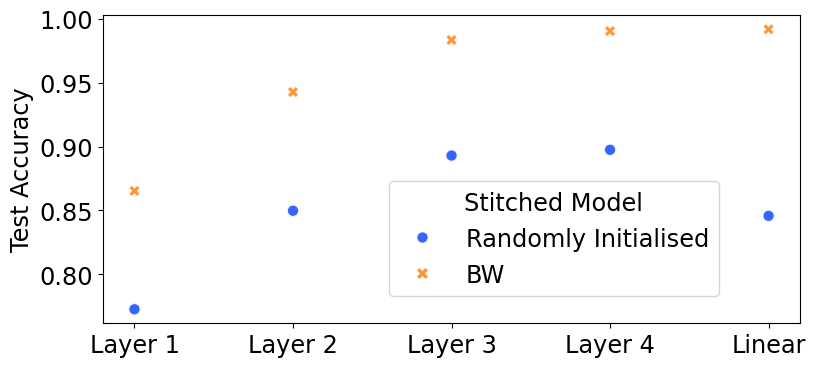

This is models stitched to BGONLY model using BW data


In [16]:
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp2n_log.txt"
save_log_as = f"./plot_results/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 

# styles to reproduce graph A5 of the NeurIPS paper "AllAcc/RankToDigit"
# But with datasets matching sender networks
makeAllRanks = True
if makeAllRanks:
    style_order = [#'Correlated', 
                   #'Digit',  
                    'Randomly Initialised',
                   #'Colour', 
                   #'Colour-Only',  
                   #'Mix', 
                   'BW',
                   #'Baseline',  
                   #'Noise'
                  ]
    send_models = {#'Baseline': '^unbias$',
                   #'Colour':         '^bg\d', # these three may learn colours as a shortcut
                   #'Colour-Only':     '^bgonly\d', 
                   #'Correlated':       '^bias\d',  
                   #'Digit':     '^unbias\d', # these three have to learn to read digits
                   'Randomly Initialised': '^randinit\d', # randomly initialised network - not trained
                   #'Mix':        '^mix\d', 
                   'BW':         '^bw\d',
                   #'Noise':      '^X\dunbias' # syntetic random data stitched in
                  }


# exp2m - randinit into Digit on Bias=Correlated dataset
csvs_from = os.path.join("./exp2_ms_with_colorMNIST/results_2n_rank/", "*.csv")
df1 = csv_to_df(csvs_from)

df = df1
del df1 #, df2, df3

# Edit names to match the whole-network naming
df['name'] = df['name'].str.replace(r'_rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^send_', '', regex=True)

df['sender'] = 'unknown'

sizes = {}
for k, v in send_models.items(): 
        
    # unsorted dataframe, but filtered to include only the data for one send model type
    selected_set = (df['model'].str.contains(v))
    df.loc[selected_set, 'sender'] = k
    sizes[k] = len((df['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# cheatingly noted the text names of the layers in order.
# Note that the stitch.s_conv1 layer appears first in the list, even though conceptually it 
# could be considered to be in the middle of the full network at the point of the cut
# This made sense for the truncated networks in part 1 but not 
layer_after_stitch = {3: 'features.4.0.conv1',
                      4: 'features.5.0.conv1',
                      5: 'features.6.0.conv1',
                      6: 'features.7.0.conv1',
                      7: 'originalfc'}

cat_order = ['features.4.0.conv1',  
             'features.5.0.conv1',  
             'features.6.0.conv1', 
             'features.7.0.conv1',  
             'originalfc']

# names for graph tick points as the above are specific to how I've cut and stitched
custom_labels = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Linear']

combined_condition = pd.Series([False] * len(df))

sizes = {}
for k, v in layer_after_stitch.items(): 

    model_match = (df['model'].str.contains(f"{k}"))
    layer_match = (df['name'].str.contains(v))
    combined_condition |= (model_match & layer_match)

    # Add in the reference model that has no stitch, was trained on unbias dataset but has bias data input to it
    if 'Baseline' in send_models:
        model_match = (df['model'].str.contains(send_models['Baseline']))
        layer_match = (df['name'].str.contains(v))
        combined_condition |= (model_match & layer_match)

df2 = df[combined_condition ].copy() 
df3 = df2[df2['sender'] != 'unknown'].copy()

#########################
sizes = {}
for k, v in send_models.items():         
    # Now that d3 has been filtered down, check again how many samples per model
    sizes[k] = len((df3['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")
#######################

# Sort the model column and create a categorical type with sorted categories 
# e.g models are X6bgonly or bgonly
df3['name'] = pd.Categorical(df3['name'], categories=cat_order, ordered=True)
# Create line plot
plt.figure(figsize=(9,4))


line_plot = sns.lineplot(data=df3, x='name', y='val_acc', hue='sender', style='sender', 
                         hue_order=style_order, style_order=style_order,
                         markers=False, dashes=False, lw=0, markersize=8, alpha=0.5, palette='bright',
                        errorbar=("pi", 100), legend=False)
# errorbar=("sd",1)) for standard deviation
# errorbar=("pi",100)) for all results
# Add markers for each individual data point
scatter_plot = sns.scatterplot(
    data=df3,
    x='name',
    y='val_acc',
    hue='sender',
    style='sender',
    hue_order=style_order,
    style_order=style_order,
    markers=True,
    s=64,  # Marker size
    alpha=0.8,
    palette='bright',
    #legend=False  # Avoid duplicate legends
)


#plt.title("Val Acc of Digit receiver stitched from senders at various layers")
#plt.xlabel('Layer Name')
plt.xlabel('')
plt.ylabel('Test Accuracy', fontsize='xx-large')
#plt.yscale('log')
#plt.xticks(rotation=0)
plt.tick_params(axis='both', labelsize='xx-large')

#plt.axhline(y=0.978, color='gray', linestyle='--', label='Baseline')

handles, labels = line_plot.get_legend_handles_labels()
#sorted_labels_handles = sorted(zip(labels, handles))
unsorted_labels_handles = zip(labels, handles)
labels, handles = zip(*unsorted_labels_handles)
plt.legend(handles, labels, title='Stitched Model', loc='upper right', bbox_to_anchor=(0.9, 0.5), fontsize='xx-large', title_fontsize='xx-large')
#plt.legend().remove()
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)

plt.savefig(f"./plot_results/2n_lin_post_stitch_acc.pdf", bbox_inches='tight')
plt.show()
print("This is models stitched to BGONLY model using BW data")

# Experiment 2j_a - Stitch VGG19 models to each other 
## (Unbias and Uninitialised senders to Unbias Receiver - unbias for stitch)
Unbias = Digit


Logging to ./plot_results/2025-05-15_14-43-03_ranks_exp2j_a_log.txt
Check number of samples per model:
{'Digit': 12, 'Randomly Initialised': 12}
Check number of samples per model:
{'Digit': 10, 'Randomly Initialised': 10}


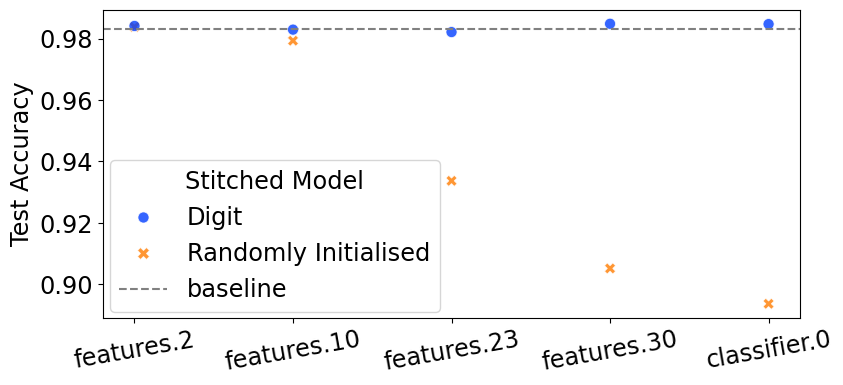

In [10]:
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp2j_a_log.txt"
save_log_as = f"./plot_results/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 

# styles to reproduce graph A5 of the NeurIPS paper "AllAcc/RankToDigit"
makeAllRanks = True
if makeAllRanks:
    style_order = [#'Correlated', 
                   'Digit',  
                   'Randomly Initialised',
                   #'Colour', 
                   #'Colour-Only',  
                   #'Mix', 
                   #'BW'
                   #'Baseline',  
                   #'Noise'
                  ]
    send_models = {#'Baseline': '^unbias$',
                   #'Colour':         '^bg\d', # these three may learn colours as a shortcut
                   #'Colour-Only':     '^bgonly\d', 
                   #'Correlated':       '^bias\d',  
                   'Digit':     '^unbias\d', # these three have to learn to read digits
                    'Randomly Initialised': '^randinit\d', # randomly initialised network - not trained
                   #'Mix':        '^mix\d', 
                   #'BW':         '^bw\d',
                   #'Noise':      '^X\dunbias' # syntetic random data stitched in
                  }


# exp2 colour_MNIST
csvs_from = os.path.join("./exp2_ms_with_colorMNIST/results_2j_a_rank/", "*.csv")
df = csv_to_df(csvs_from)

# exp1 Synthetic stitch
#csvs_from = os.path.join("./exp1_ms_with_random_dataset/results_2j_rank/", "*.csv")
#df2 = csv_to_df(csvs_from)

# select only the data for synthetic data stitched into the unbias-trained network 
#df3 = df2[df2['model'].str.contains('^X\dunbias')].copy()

#df = pd.concat([df1, df3], ignore_index=True)
#del df1, df2, df3

# Edit names to match the whole-network naming
df['name'] = df['name'].str.replace(r'_rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^send_', '', regex=True)

df['sender'] = 'unknown'

sizes = {}
for k, v in send_models.items(): 
        
    # unsorted dataframe, but filtered to include only the data for one send model type
    selected_set = (df['model'].str.contains(v))
    df.loc[selected_set, 'sender'] = k
    sizes[k] = len((df['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# cheatingly noted the text names of the layers in order.
# Note that the stitch.s_conv1 layer appears first in the list, even though conceptually it 
# could be considered to be in the middle of the full network at the point of the cut
# This made sense for the truncated networks in part 1 but not 

layer_after_stitch = {1: 'features.2'  ,
                      8: 'features.10'  ,
                     22: 'features.23' ,
                     29: 'features.30' ,
                     35: 'classifier.0'
                     }
'''
category_order = ['features.2'  ,
                  'features.10'  ,
                  'features.23' ,
                  'features.30' ,
                  'classifier.0']

custom_labels = category_order
'''
cat_order = [ # 'ref', 
                  'features.2'  ,
                  'features.10'  ,
                  'features.23' ,
                  'features.30' ,
                  'classifier.0']

# names for graph tick points as the above are specific to how I've cut and stitched
custom_labels =  [#'Whole', 
                  'features.2'  ,
                  'features.10'  ,
                  'features.23' ,
                  'features.30' ,
                  'classifier.0']

combined_condition = pd.Series([False] * len(df))

sizes = {}
for k, v in layer_after_stitch.items(): 

    model_match = (df['model'].str.contains(f"{k}"))
    layer_match = (df['name'].str.contains("only"))
    combined_condition |= (model_match & layer_match)
    #print(f"{k=} {v=}")
    #print(df[(model_match & layer_match)])
    df.loc[(model_match & layer_match), 'name'] = v
    #print("Edit the name field")
    #print(df[(model_match & layer_match)])
    # Add in the reference model that has no stitch, was trained on unbias dataset but has bias data input to it
    if 'Baseline' in send_models:
        model_match = (df['model'].str.contains(send_models['Baseline']))
        layer_match = (df['name'].str.contains("only"))
        combined_condition |= (model_match & layer_match)
        df.loc[(model_match & layer_match), 'name'] = 'ref'

df2 = df[combined_condition ].copy() 
df3 = df2[df2['sender'] != 'unknown'].copy()

#########################
sizes = {}
for k, v in send_models.items():         
    # Now that d3 has been filtered down, check again how many samples per model
    sizes[k] = len((df3['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")
#######################

# Sort the model column and create a categorical type with sorted categories 
# e.g models are X6bgonly or bgonly
df3['name'] = pd.Categorical(df3['name'], categories=cat_order, ordered=True)


# Create line plot
plt.figure(figsize=(9,4))

line_plot = sns.lineplot(data=df3, x='name', y='val_acc', hue='sender', style='sender', 
                         hue_order=style_order, style_order=style_order,
                         markers=False, dashes=False, lw=0, markersize=8, alpha=0.5, palette='bright',
                        errorbar=("pi", 100), legend=False)
# errorbar=("sd",1)) for standard deviation
# errorbar=("pi",100)) for all results
# Add markers for each individual data point
scatter_plot = sns.scatterplot(
    data=df3,
    x='name',
    y='val_acc',
    hue='sender',
    style='sender',
    hue_order=style_order,
    style_order=style_order,
    markers=True,
    s=64,  # Marker size
    alpha=0.8,
    palette='bright',
    #legend=False  # Avoid duplicate legends
)

#line_plot = sns.lineplot(data=df3, x='name', y='val_acc', hue='sender', style='sender', 
#                         hue_order=style_order, style_order=style_order,
#                         markers=True, dashes=True, markersize=8, alpha=0.5, palette='bright',
#                        errorbar=("pi", 100))
# errorbar=("sd",1)) for standard deviation
# errorbar=("pi",100)) for all results



#plt.title("Val Acc of Digit receiver stitched from senders at various layers")
#plt.xlabel('Layer Name')
plt.xlabel('')
plt.ylabel('Test Accuracy', fontsize='xx-large')
#plt.yscale('log')
#plt.ylim([0.98, 1.001])
plt.xticks(rotation=10)
plt.tick_params(axis='both', labelsize='xx-large')

plt.axhline(y=0.9832, color='gray', linestyle='--', label='baseline')

handles, labels = line_plot.get_legend_handles_labels()
#sorted_labels_handles = sorted(zip(labels, handles))
unsorted_labels_handles = zip(labels, handles)
labels, handles = zip(*unsorted_labels_handles)
plt.legend(handles, labels, title='Stitched Model', loc='upper right', bbox_to_anchor=(0.5, 0.55), fontsize='xx-large', title_fontsize='xx-large')
#plt.legend().remove()
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
plt.savefig(f"./plot_results/2j_a_VGG_lin_post_stitch_acc_sd.pdf", bbox_inches='tight')
plt.show()
# penguin

In [ ]:

combined_condition = pd.Series([False] * len(df))

# The models which have no stitch - use to get a first point on the graph for training against real data
ref_models  = {
               #'Colour':        '^bg$', # these three may learn colours as a shortcut
               #'Colour-Only':   '^bgonly$', 
               #'Correlated':    '^bias$',  
               'Digit':         '^unbias$', # these three have to learn to read digits
               'Randomly Initialised': '^randinit$',
               #'Mix':           '^mix$', 
               #'BW':            '^bw$'
                }

accuracies = {}
for k, v in ref_models.items(): 

    model_match = (df['model'].str.contains(v))
    layer_match = (df['name'].str.contains('only'))
    condition = (model_match & layer_match)
    print(f"For {k} found {sum(condition)} examples")
    #combined_condition |= condition
    #print(df[condition]['val_acc'])
    #print(df[condition]['val_acc'].mean())
    accuracies[k] = df[condition]['val_acc'].mean()

print("The following networks with validation accuracies measured against unbias (Digit) dataset")
print(accuracies)